# Ensaio de teste SDRPLAY
Teste do SDRPlay para verificar condições de operação quando comparado ao RTL-SDR

## Imports

In [1]:
from pylab import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import control
from time import sleep
import math


import SoapySDR as sp


## Parâmetros de ensaio

In [2]:
sample_rate = 1e6
center_freq = 92.1e6

## Funções estruturantes

In [3]:
def fazer_aquisicao(sample_rate, center_freq, gain, nsamples):
    if sample_rate < 1e6:
        print("sample_rate precisa estar entre 1e6 e 2e6")
        return
    if gain < 1:
        print("gain precisa ser maior igual a 1")
   
    args = dict(driver="sdrplay")
    sdr = sp.Device(args)
    rx_chan = 0
    gain = 42 - gain
    sdr.setSampleRate(sp.SOAPY_SDR_RX, rx_chan, sample_rate)
    sdr.setFrequency(sp.SOAPY_SDR_RX, rx_chan, center_freq)
    sdr.setGainMode(sp.SOAPY_SDR_RX, rx_chan, False) # turn off AGC
    sdr.setGain(sp.SOAPY_SDR_RX, rx_chan, gain)
   
    max_nsamples = 32256
    rodadas = 1
    if nsamples > max_nsamples:
        rodadas = math.ceil(nsamples/max_nsamples)

    print("[INFO]Para", nsamples, "serão feitas", rodadas, "medidas")
    rxStream = sdr.setupStream(sp.SOAPY_SDR_RX, sp.SOAPY_SDR_CF32)
    print("faxa de ganho")
    print(sdr.getGainRange(sp.SOAPY_SDR_RX, rx_chan))
    
    print("[DONE]setup")
    
    sdr.activateStream(rxStream) #start streaming
    print("[DONE]activateStream")
    
    _samples = np.array([0]*max_nsamples, np.complex64)
    samples = np.array([], np.complex64)
    mperdidas = 0;
    for j in range(rodadas):        
        for i in range(20):
            sr = sdr.readStream(rxStream, [_samples], len(_samples))
            if sr.ret > 0:                
                break
            if i == 19:
                mperdidas = mperdidas + 1
                print("[ERROR]readStream", sr.ret)
                print("[INFO]", mperdidas, "/", rodadas, "medidas perdidas")
                break
        samples = np.concatenate([samples, _samples])
    sdr.deactivateStream(rxStream) #stop streaming
    sdr.closeStream(rxStream)
    sleep(1)
    print("[DONE]fechou")
    return samples

def fazer_grafico(samples, sample_rate, center_freq):
    if sample_rate < 1e6:
        print("sample_rate precisa ser maior igual a 1e6")
        return
    if center_freq < 1e6:
        print("center_freq precisa ser maior igual a 1e6")
        return    
    NFFT = 1024
    plt.figure()
    plt.psd(samples, NFFT=NFFT, Fs=sample_rate/1e6, Fc=center_freq/1e6, color='crimson')    
    
    xlabel('Frequency (MHz)')
    ylabel('Relative power (dB)') 
    
    plt.savefig("psd.png")
    
def obter_magnitude(freq, samples, sample_rate, center_freq):
    if sample_rate < 1e6:
        print("sample_rate precisa ser maior igual a 1e6")
        return
    if center_freq < 1e6:
        print("center_freq precisa ser maior igual a 1e6")
        return
    sample_rate = sample_rate/1e6
    center_freq = center_freq/1e6
    freq = freq/1e6
    NFFT = 1024
    axes = psd(samples, NFFT=NFFT, Fs=sample_rate)
    y = 10*np.log10(axes[0])
    x = axes[1] + center_freq
    i = find_nearest(x, freq)    
    return x[i],y[i]

def find_nearest(array, value):
    #https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def obter_magnitude_sem_ganho(mag, ganho):
    amp = control.db2mag(mag)/ganho
    return 20*np.log10(amp)


## Medição G=1; 

[INFO]Para 1024 serão feitas 1 medidas
faxa de ganho
0, 42
[DONE]setup
[DONE]activateStream
[DONE]fechou
Na frequência 92.1 a magnitude é de -69.48485751008289 dB


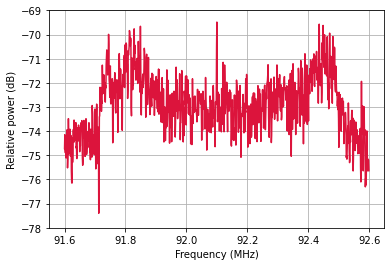

In [4]:
samples = fazer_aquisicao(
    sample_rate = sample_rate,
    center_freq = center_freq,
    gain = 1,
    nsamples = 1024
)
fazer_grafico(
    samples = samples,
    sample_rate = sample_rate,
    center_freq = center_freq
)
freq, mag = obter_magnitude(
    freq = center_freq,
    samples = samples,
    sample_rate = sample_rate,
    center_freq = center_freq
)
print("Na frequência", freq, "a magnitude é de", mag, "dB")

## Medição G=7; 

[INFO]Para 524288 serão feitas 17 medidas
faxa de ganho
0, 42
[DONE]setup
[DONE]activateStream
[DONE]fechou
Na frequência 92.1 a magnitude é de -60.65336166668992 dB


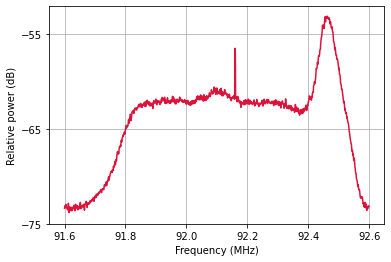

In [5]:
samples = fazer_aquisicao(
    sample_rate = sample_rate,
    center_freq = center_freq,
    gain = 7,
    nsamples = 1024*512
)
fazer_grafico(
    samples = samples,
    sample_rate = sample_rate,
    center_freq = center_freq
)
freq, mag = obter_magnitude(
    freq = center_freq,
    samples = samples,
    sample_rate = sample_rate,
    center_freq = center_freq
)
print("Na frequência", freq, "a magnitude é de", mag, "dB")

# Conclusão comparativo
- Ambos SDR apresentam medidas que são compativeis com a realidade. Existe de fato uma estação de rádio cuja portadora está em 92.1MHz.
- A magnitude da potência na frequência central do RTL-SDR é maior que a obtida com o SDRPlay, ambos com ganho=1, ambas medições utilizando a mesma antena e sendo adquiridas ao mesmo tempo.
- Realizando a mesma medição porém ganho=7 o cenário se inverte. A magnitude de potência na frequência central do RTL-SDR é menor que a obtida com o SDRPlay.
- O SDRPlay não precisa de tratamento nas medidas obtidas, ao contrário do RTL-SDR